# Renaming Fasta Sequences for Easy-to-Read Phylogenetic Trees

## Main Idea:

The Python code below modifies the labels of Fasta protein sequences to include the gene and species name.

These labels make multiple sequence alignments and phylogenetic trees generated from these sequences much easier to read.

## Background:

The labels of Fasta sequences conventionally begin with an accession number: an alphanumeric string that uniquely identifies the sequence of interest within a database (e.g. "P19525.2" from UniProtKB in the sequence below). Accession numbers are helpful for disambiguating sequences with similar names (or different versions of the same sequence), but they aren't very easy for people to read.

<span style="color:black; font-family:'Courier New'">>P19525.2 RecName: Full=Interferon-induced, double-stranded RNA-activated protein kinase; AltName: Full=Eukaryotic translation initiation factor 2-alpha kinase 2; Short=eIF-2A protein kinase 2; AltName: Full=Interferon-inducible RNA-dependent protein kinase; AltName: Full=P1/eIF-2A protein kinase; AltName: Full=Protein kinase RNA-activated; Short=PKR; Short=Protein kinase R; AltName: Full=Tyrosine-protein kinase EIF2AK2; AltName: Full=p68 kinase [Homo sapiens]
MAGDLSAGFFMEELNTYRQKQGVVLKYQELPNSGPPHDRRFTFQVIIDGREFPEGEGRSKKEAKNAAAKLAVEILNKEKK
AVSPLLLTTTNSSEGLSMGNYIGLINRIAQKKRLTVNYEQCASGVHGPEGFHYKCKMGQKEYSIGTGSTKQEAKQLAAKL
AYLQILSEETSVKSDYLSSGSFATTCESQSNSLVTSTLASESSSEGDFSADTSEINSNSDSLNSSSLLMNGLRNNQRKAK
RSLAPRFDLPDMKETKYTVDKRFGMDFKEIELIGSGGFGQVFKAKHRIDGKTYVIKRVKYNNEKAEREVKALAKLDHVNI
VHYNGCWDGFDYDPETSDDSLESSDYDPENSKNSSRSKTKCLFIQMEFCDKGTLEQWIEKRRGEKLDKVLALELFEQITK
GVDYIHSKKLIHRDLKPSNIFLVDTKQVKIGDFGLVTSLKNDGKRTRSKGTLRYMSPEQISSQDYGKEVDLYALGLILAE
LLHVCDTAFETSKFFTDLRDGIISDIFDKKEKTLLQKLLSKKPEDRPNTSEILRTLTVWKKSPEKNERHTC </span>

Multiple sequence alignment tools often use accession numbers to label each sequence. For example, the image below shows the beginning of a Clustal O alignment of 21 protein kinase sequences (somewhat arbitrarily chosen for the sake of this example). It's hard to interpret the biological significance of this alignment without labels that indicate which sequence comes from which protein (and which species).

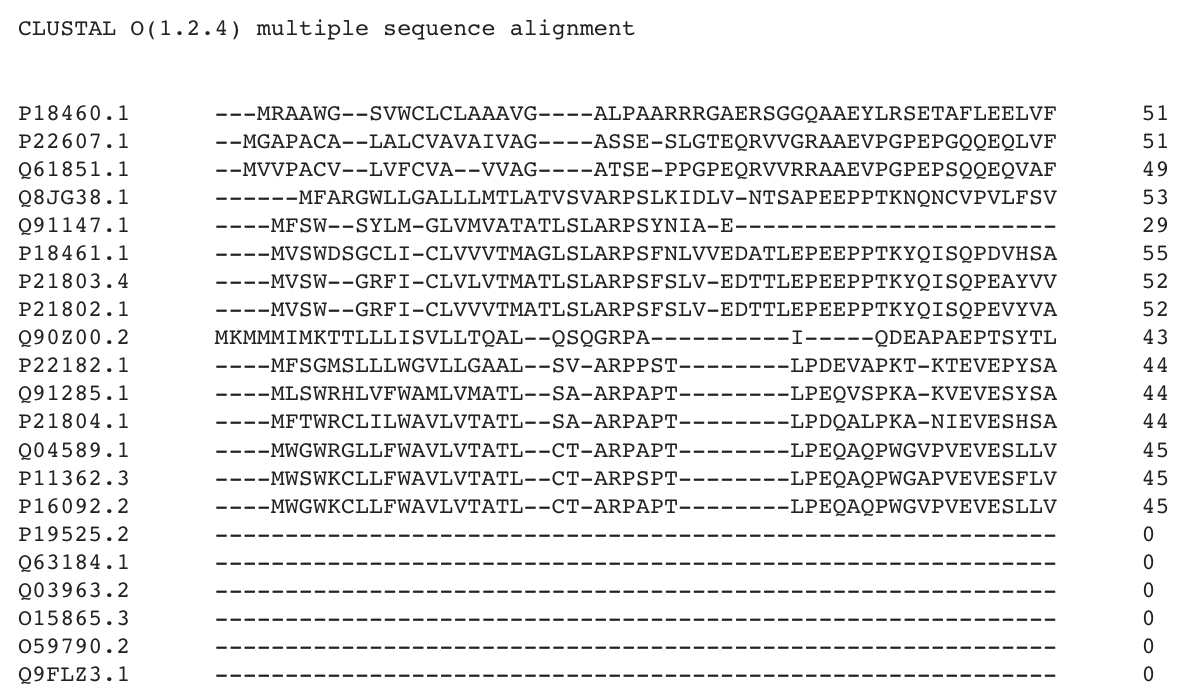

The same problem applies to the phylogenetic trees. Again, you can see that some sequences are more closely related than others, but what those sequences are (and what those relationships mean) is not immediately obvious.

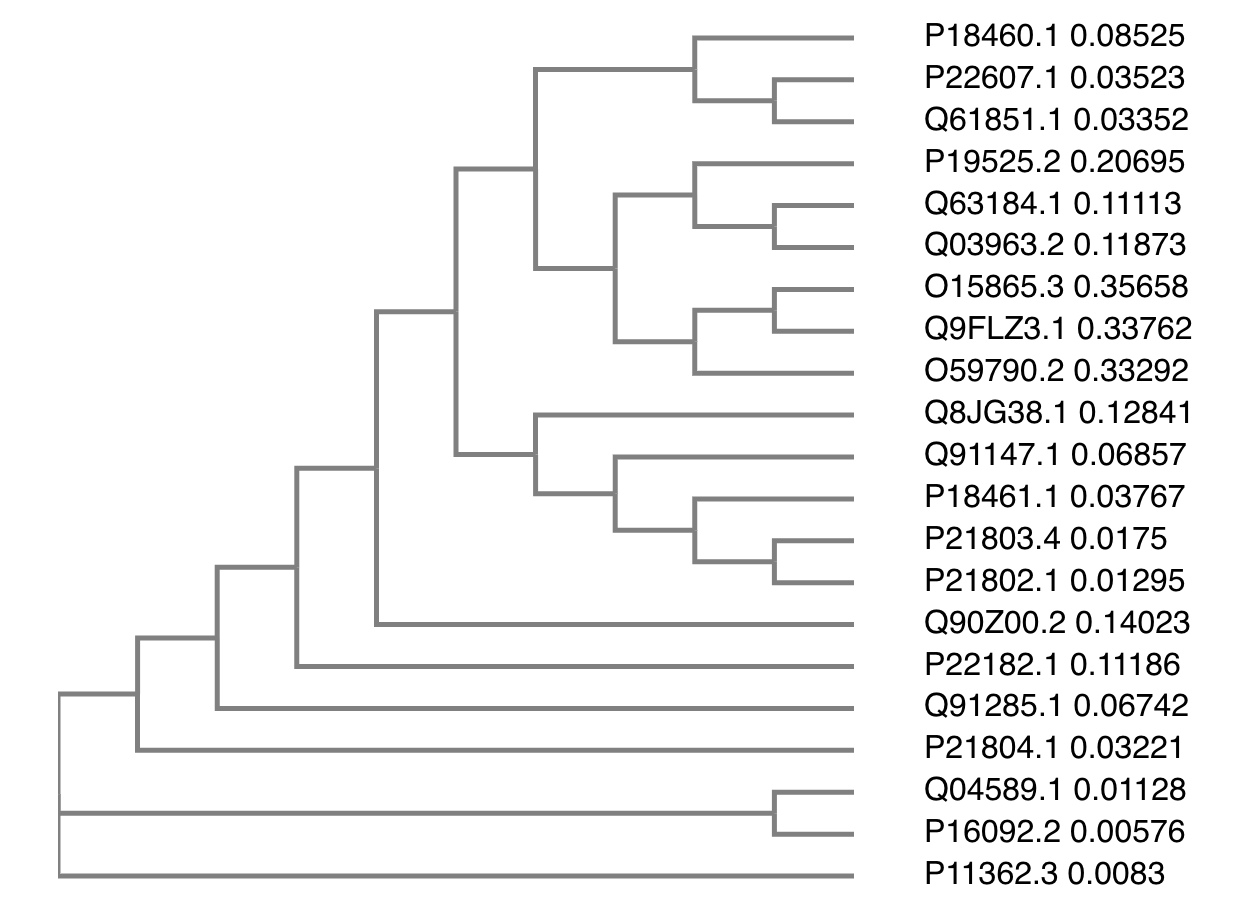

Unfortunately, most web-based multiple sequence alignment tools do not give users the option to change way that sequences are labeled. In order to generate visuals that are easy to read, you need to change the labels of each Fasta sequence before uploading the sequences into the tool.

There isn't much room in a multiple sequence alignment or phylogenetic tree for a long label, so I decided to use the gene name abbreviation  followed by the species name. Where possible, I translated the scientific name of the species to the common name to make the tree even easier to read. I kept the accession number on at the end to prevent ambiguity.

Renaming each sequence involved the following steps:
- Parsing the Fasta file with the SeqIO package from Biopython
- Retrieving the UniProtKB ID from each sequence header
- Accessing the UniProt ID Mapping tool to retrieve the gene names
- Isolating the scientific name of each species from the sequence header
- Retrieving the common name for each species from Entrez
- Changing the label of each sequence
- Outputting the relabeled sequences as a Fasta file

As a result, for example, "Q61851.1" becomes "Fgfr3_mouse_Q61851.1". When the re-labeled sequences are using to re-generate the multiple sequence alignment and phylogenetic tree above, they become much easier to read!

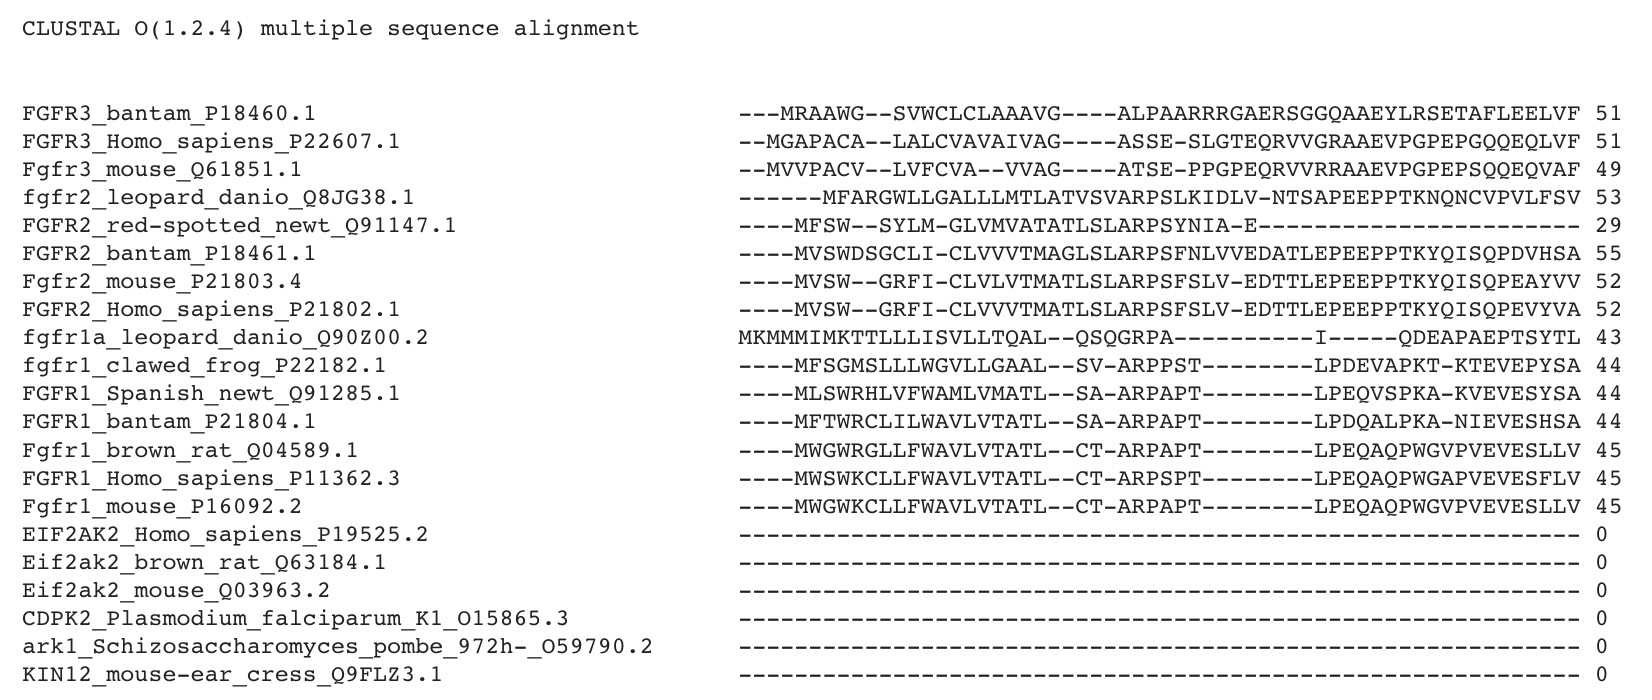

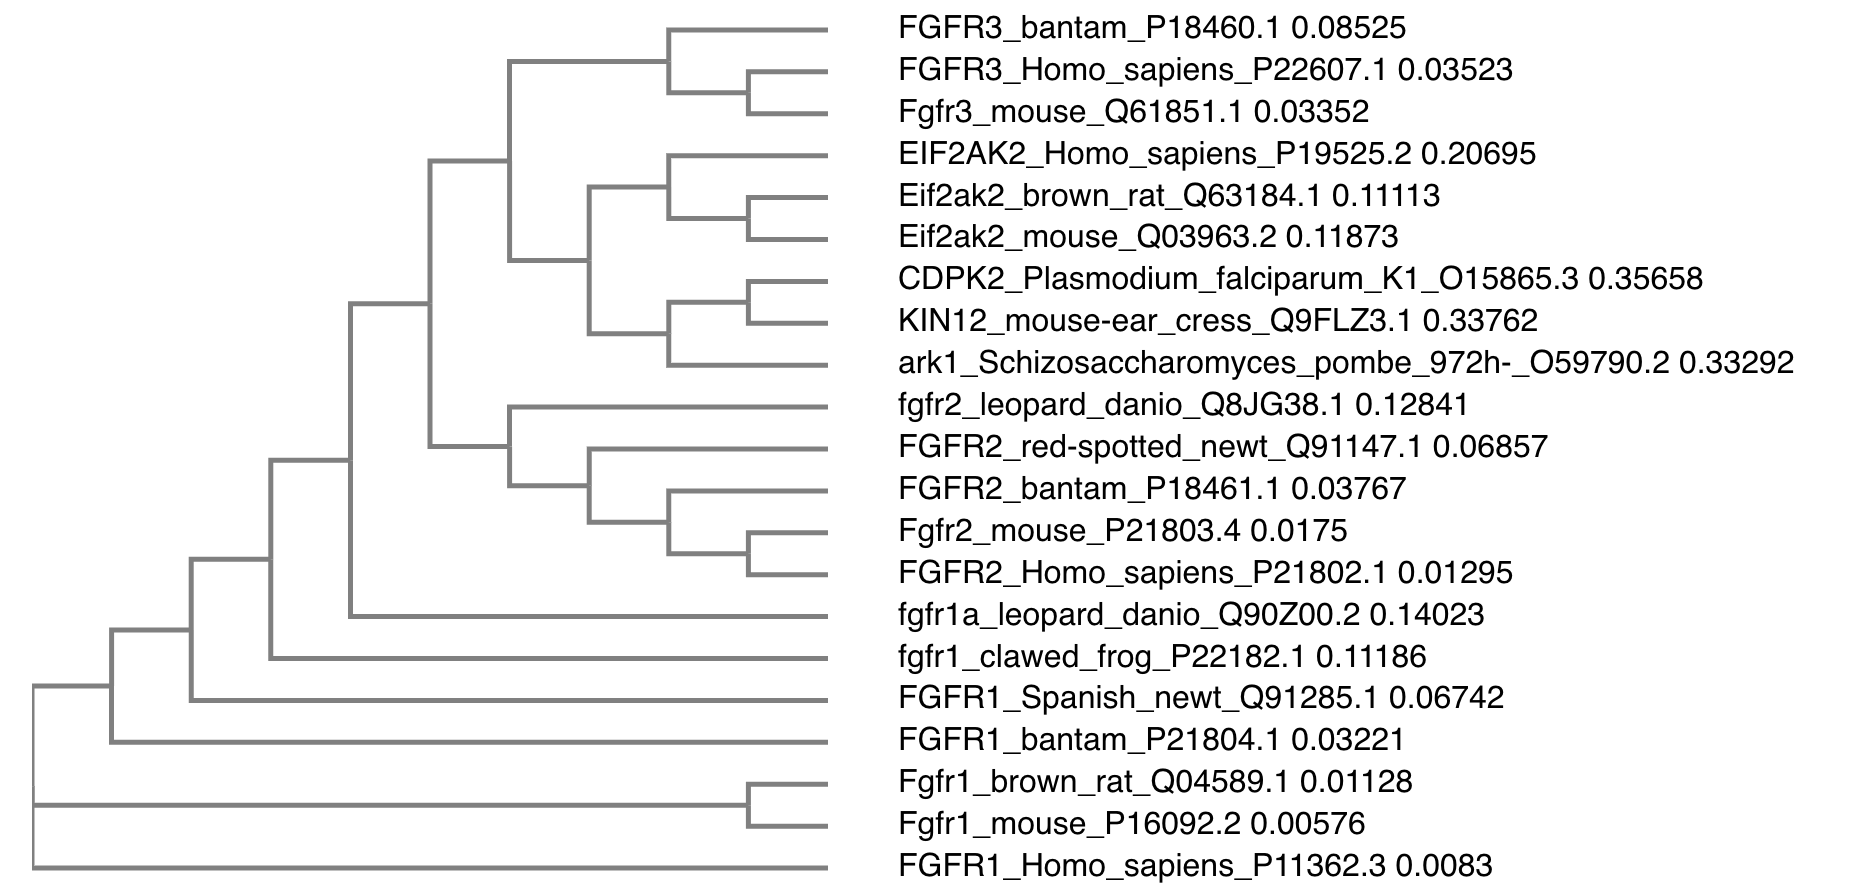

## Explaining the Code:

Here's the file header and list of libraries/packages I used. I want to point out two specific features here: when you access Entrez, you need to provide your email address. [Getting an API key from Entrez](https://support.nlm.nih.gov/knowledgebase/article/KA-05317/en-us) is optional, but the database will allow you to make more queries per second (10 vs. 3) if you use one. You can also use the time.sleep() function to space out your queries so that you don't exceed this limit.

In [32]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Oct  5 23:23:37 2022

@author: Beth Graham
"""

from Bio import SeqIO
from Bio import Entrez
Entrez.email = ""
#Entrez.api_key = ""

import re
import time
import json
import zlib
from xml.etree import ElementTree
from urllib.parse import urlparse, parse_qs, urlencode
import requests
from requests.adapters import HTTPAdapter, Retry

The first step is to parse the Fasta input file. [SeqIO.parse()](https://biopython.org/wiki/SeqIO) from Biopython will turn each Fasta sequence into a SeqRecord object, which makes each attribute of the sequence (e.g. the "id", which in this case is the UniProtKB accession number) really to easy retrieve:

In [33]:
input_list = SeqIO.parse("input_file.fa", "fasta")

fa_seqs_OG = []
accession_list = []

for record in input_list:
    fa_seqs_OG.append(record)
    accession_list.append(record.id)

print("%s \n" %fa_seqs_OG[1])
print("%s \n" %fa_seqs_OG[1].id)
print("%s" %accession_list)

ID: Q63184.1
Name: Q63184.1
Description: Q63184.1 RecName: Full=Interferon-induced, double-stranded RNA-activated protein kinase; AltName: Full=Eukaryotic translation initiation factor 2-alpha kinase 2; Short=eIF-2A protein kinase 2; AltName: Full=Interferon-inducible RNA-dependent protein kinase; AltName: Full=Protein kinase RNA-activated; Short=PKR; Short=Protein kinase R; AltName: Full=Tyrosine-protein kinase EIF2AK2 [Rattus norvegicus]
Number of features: 0
Seq('MASDTPGFYVDKLNKYSQIHKVKIIYKEISVTGPPHDRRFTFQVIIEEREFPEG...NTC') 

Q63184.1 

['P19525.2', 'Q63184.1', 'Q03963.2', 'P11362.3', 'Q04589.1', 'P16092.2', 'P21804.1', 'Q91285.1', 'P18460.1', 'P18461.1', 'P22607.1', 'P21803.4', 'P21802.1', 'O59790.2', 'Q8JG38.1', 'P22182.1', 'Q90Z00.2', 'Q61851.1', 'O15865.3', 'Q9FLZ3.1', 'Q91147.1']


The next step is to use UniProtKB's ID Mapping tool to retrieve the gene name that corresponds to each UniProtKB ID. The next large chunk of sequence is almost entirely provided by UniProt:

In [34]:
# The following chunk of code is provided by the UniProt website
# https://www.uniprot.org/help/id_mapping

POLLING_INTERVAL = 3
API_URL = "https://rest.uniprot.org"


retries = Retry(total=5, backoff_factor=0.25, status_forcelist=[500, 502, 503, 504])
session = requests.Session()
session.mount("https://", HTTPAdapter(max_retries=retries))


def check_response(response):
    try:
        response.raise_for_status()
    except requests.HTTPError:
        print(response.json())
        raise


def submit_id_mapping(from_db, to_db, ids):
    request = requests.post(
        f"{API_URL}/idmapping/run",
        data={"from": from_db, "to": to_db, "ids": ",".join(ids)},
    )
    check_response(request)
    return request.json()["jobId"]


def get_next_link(headers):
    re_next_link = re.compile(r'<(.+)>; rel="next"')
    if "Link" in headers:
        match = re_next_link.match(headers["Link"])
        if match:
            return match.group(1)


def check_id_mapping_results_ready(job_id):
    while True:
        request = session.get(f"{API_URL}/idmapping/status/{job_id}")
        check_response(request)
        j = request.json()
        if "jobStatus" in j:
            if j["jobStatus"] == "RUNNING":
                print(f"Retrying in {POLLING_INTERVAL}s")
                time.sleep(POLLING_INTERVAL)
            else:
                raise Exception(j["jobStatus"])
        else:
            return bool(j["results"] or j["failedIds"])


def get_batch(batch_response, file_format, compressed):
    batch_url = get_next_link(batch_response.headers)
    while batch_url:
        batch_response = session.get(batch_url)
        batch_response.raise_for_status()
        yield decode_results(batch_response, file_format, compressed)
        batch_url = get_next_link(batch_response.headers)


def combine_batches(all_results, batch_results, file_format):
    if file_format == "json":
        for key in ("results", "failedIds"):
            if key in batch_results and batch_results[key]:
                all_results[key] += batch_results[key]
    elif file_format == "tsv":
        return all_results + batch_results[1:]
    else:
        return all_results + batch_results
    return all_results


def get_id_mapping_results_link(job_id):
    url = f"{API_URL}/idmapping/details/{job_id}"
    request = session.get(url)
    check_response(request)
    return request.json()["redirectURL"]


def decode_results(response, file_format, compressed):
    if compressed:
        decompressed = zlib.decompress(response.content, 16 + zlib.MAX_WBITS)
        if file_format == "json":
            j = json.loads(decompressed.decode("utf-8"))
            return j
        elif file_format == "tsv":
            return [line for line in decompressed.decode("utf-8").split("\n") if line]
        elif file_format == "xlsx":
            return [decompressed]
        elif file_format == "xml":
            return [decompressed.decode("utf-8")]
        else:
            return decompressed.decode("utf-8")
    elif file_format == "json":
        return response.json()
    elif file_format == "tsv":
        return [line for line in response.text.split("\n") if line]
    elif file_format == "xlsx":
        return [response.content]
    elif file_format == "xml":
        return [response.text]
    return response.text


def get_xml_namespace(element):
    m = re.match(r"\{(.*)\}", element.tag)
    return m.groups()[0] if m else ""


def merge_xml_results(xml_results):
    merged_root = ElementTree.fromstring(xml_results[0])
    for result in xml_results[1:]:
        root = ElementTree.fromstring(result)
        for child in root.findall("{http://uniprot.org/uniprot}entry"):
            merged_root.insert(-1, child)
    ElementTree.register_namespace("", get_xml_namespace(merged_root[0]))
    return ElementTree.tostring(merged_root, encoding="utf-8", xml_declaration=True)


def print_progress_batches(batch_index, size, total):
    n_fetched = min((batch_index + 1) * size, total)
    print(f"Fetched: {n_fetched} / {total}")


def get_id_mapping_results_search(url):
    parsed = urlparse(url)
    query = parse_qs(parsed.query)
    file_format = query["format"][0] if "format" in query else "json"
    if "size" in query:
        size = int(query["size"][0])
    else:
        size = 500
        query["size"] = size
    compressed = (
        query["compressed"][0].lower() == "true" if "compressed" in query else False
    )
    parsed = parsed._replace(query=urlencode(query, doseq=True))
    url = parsed.geturl()
    request = session.get(url)
    check_response(request)
    results = decode_results(request, file_format, compressed)
    total = int(request.headers["x-total-results"])
    print_progress_batches(0, size, total)
    for i, batch in enumerate(get_batch(request, file_format, compressed), 1):
        results = combine_batches(results, batch, file_format)
        print_progress_batches(i, size, total)
    if file_format == "xml":
        return merge_xml_results(results)
    return results


def get_id_mapping_results_stream(url):
    if "/stream/" not in url:
        url = url.replace("/results/", "/results/stream/")
    request = session.get(url)
    check_response(request)
    parsed = urlparse(url)
    query = parse_qs(parsed.query)
    file_format = query["format"][0] if "format" in query else "json"
    compressed = (
        query["compressed"][0].lower() == "true" if "compressed" in query else False
    )
    return decode_results(request, file_format, compressed)


job_id = submit_id_mapping(
    from_db="UniProtKB_AC-ID", to_db="Gene_Name", ids=accession_list
)
if check_id_mapping_results_ready(job_id):
    link = get_id_mapping_results_link(job_id)
    from_to_list = get_id_mapping_results_search(link)

# This is the end of the code provided by UniProt


# Verify that it worked:
print(from_to_list)

Fetched: 21 / 21
{'results': [{'from': 'P19525.2', 'to': 'EIF2AK2'}, {'from': 'Q63184.1', 'to': 'Eif2ak2'}, {'from': 'Q03963.2', 'to': 'Eif2ak2'}, {'from': 'P11362.3', 'to': 'FGFR1'}, {'from': 'Q04589.1', 'to': 'Fgfr1'}, {'from': 'P16092.2', 'to': 'Fgfr1'}, {'from': 'P21804.1', 'to': 'FGFR1'}, {'from': 'Q91285.1', 'to': 'FGFR1'}, {'from': 'P18460.1', 'to': 'FGFR3'}, {'from': 'P18461.1', 'to': 'FGFR2'}, {'from': 'P22607.1', 'to': 'FGFR3'}, {'from': 'P21803.4', 'to': 'Fgfr2'}, {'from': 'P21802.1', 'to': 'FGFR2'}, {'from': 'O59790.2', 'to': 'ark1'}, {'from': 'Q8JG38.1', 'to': 'fgfr2'}, {'from': 'P22182.1', 'to': 'fgfr1'}, {'from': 'Q90Z00.2', 'to': 'fgfr1a'}, {'from': 'Q61851.1', 'to': 'Fgfr3'}, {'from': 'O15865.3', 'to': 'CDPK2'}, {'from': 'Q9FLZ3.1', 'to': 'KIN12'}, {'from': 'Q91147.1', 'to': 'FGFR2'}]}


In this case, the output is a dictionary that only contains one key ('results'). If the ID Mapping tool is not able to retrieve a gene name for a given ID, this dictionary will contain a second key ('failedIDs'). This is accounted for in the code below.

The SeqRecord object for each sequence contains "id" and "name" attributes that are (often? always?) identical in Fasta files. In this case, both the "id" and "name" attributes contain the UniProtKB ID. This means we can change one without losing any information! The next chunk of code changes the "name" attribute of each SeqRecord object to the gene name.

In [35]:
# This is just a backup step so I don't have to parse the original file
#  again while I work on the code:

fa_seqs = fa_seqs_OG

# Now that we have the gene name that matches each UniProtKB ID, we want
# to add the gene name to the SeqRecord.
# In this case, the "name" and "id" contain the same information, so 
# we can change the "name" attribute without losing any information.
# If no gene name was retrieved, we will leave the "Name" as-is.

for record in fa_seqs:
    if "failedIds" in from_to_list.keys():
        if record.name in from_to_list["failedIds"]:
            pass
        else:
            for entry in from_to_list["results"]:
                if record.id == entry["from"]:
                    record.name = entry["to"]
    else:
        for entry in from_to_list["results"]:
            if record.id == entry["from"]:
                record.name = entry["to"]        


# Verify that it worked
                
for record in fa_seqs:
    print(record.id, record.name)

P19525.2 EIF2AK2
Q63184.1 Eif2ak2
Q03963.2 Eif2ak2
P11362.3 FGFR1
Q04589.1 Fgfr1
P16092.2 Fgfr1
P21804.1 FGFR1
Q91285.1 FGFR1
P18460.1 FGFR3
P18461.1 FGFR2
P22607.1 FGFR3
P21803.4 Fgfr2
P21802.1 FGFR2
O59790.2 ark1
Q8JG38.1 fgfr2
P22182.1 fgfr1
Q90Z00.2 fgfr1a
Q61851.1 Fgfr3
O15865.3 CDPK2
Q9FLZ3.1 KIN12
Q91147.1 FGFR2


As it says in the comments below, the next chunk of code looks for the scientific name of the species within square brackets in the "description" attribute. For example, the code takes this ...

"Q63184.1 RecName: Full=Interferon-induced, double-stranded RNA-activated protein kinase; AltName: Full=Eukaryotic translation initiation factor 2-alpha kinase 2; Short=eIF-2A protein kinase 2; AltName: Full=Interferon-inducible RNA-dependent protein kinase; AltName: Full=Protein kinase RNA-activated; Short=PKR; Short=Protein kinase R; AltName: Full=Tyrosine-protein kinase EIF2AK2 \[Rattus norvegicus\]"

... and returns this:

"Rattus norvegicus"

The code then replaces the longer description with the scientific name of the species. If the species name is not included in the Fasta header, the species name is set as "sp?".

Finally, the chunk of code below takes the list of species (which may contain redundant entries) and turns it in to a non-redundant set. This set will later be used to query Entrez to find the common name of the species, so eliminating redundancy reduces the number of times that the Entrez database needs to be queried.

In [36]:
# Retrieve the species name

# Most of the SeqRecord objects have the species name in square brackets
# within the "description". Here, we will remove everything from the
# description except for the species name.

# We will also create a non-redundant list (set) of species so that we can
# minimize the number of times we need to search the Entrez database to find
# the corresponding common names. 

species = ""
split_species = []
species_list = []
species_set = ()

for record in fa_seqs:    
    species = record.description.split("[")[1].rstrip("]")
    if species != "":
        species_list.append(species)
        record.description = species
    else:
        record.description = "sp?"
        
species_set = set(species_list)
print(species_set)

{'Homo sapiens', 'Rattus norvegicus', 'Pleurodeles waltl', 'Arabidopsis thaliana', 'Danio rerio', 'Xenopus laevis', 'Notophthalmus viridescens', 'Mus musculus', 'Plasmodium falciparum K1', 'Schizosaccharomyces pombe 972h-', 'Gallus gallus'}


The next chunk of code adds "\[SCIN\]" (for "scientific name") to the end of the species name to generate a search query. It then uses the Entrez package in the Biopython library to query the "taxonomy" database. This search returns the numerical ID that Entrez uses for each species. The code generates a dictionary that associates each scientific name with its Entrez Species ID. If the search does not return any results, the Species ID is set as "unknown".

Note that a sleep time of 1 second is probably excessive, but the NCBI databases have been angry with me lately for making too many queries, so I played it safe. In theory, you should be able to set the sleep parameter to 0.1 seconds if you use an API key and 0.34 seconds if you don't (because you are limited to 10 or 3 searches per second, respectively).

In [40]:
# Retrieve the Entrez ID associated with each scientific species name   

sci_to_ID = {}

for unique_species in species_set:
    search_term = ""
    search_term = unique_species + "[SCIN]"
    tax_search_HTTPRO = Entrez.esearch(db = "taxonomy", term = search_term)
    tax_search = Entrez.read(tax_search_HTTPRO)
    tax_search_HTTPRO.close()
    if tax_search["IdList"] != []:
        species_ID = tax_search["IdList"]
    else:
        species_ID = "unknown"
    sci_to_ID[unique_species] = species_ID
    time.sleep(1)
    
print(sci_to_ID)

{'Homo sapiens': ['9606'], 'Rattus norvegicus': ['10116'], 'Pleurodeles waltl': ['8319'], 'Arabidopsis thaliana': ['3702'], 'Danio rerio': ['7955'], 'Xenopus laevis': ['8355'], 'Notophthalmus viridescens': ['8316'], 'Mus musculus': ['10090'], 'Plasmodium falciparum K1': ['5839'], 'Schizosaccharomyces pombe 972h-': ['284812'], 'Gallus gallus': ['9031']}


The next chunk of code uses the Entrez Species ID to retrieve information about each species from the taxonomy database. If the species record contains one or more common names, the first name that is listed will be associated with the scientific name in a new dictionary. Many species records (including <i>Homo sapiens</i>!) do not include a common name; in this case, the scientific name was used instead.

In [41]:
# Use the Entrez ID to retrieve the species common name
# Make a dictionary that associates corresponding scientific and common names

sci_to_common = {}
    
for key, value in sci_to_ID.items():
    common = ""    
    if value != [] and value != "unknown":
        ID_fetch_HTTPRO = Entrez.efetch(db = "taxonomy", id = value)
        ID_fetch = Entrez.read(ID_fetch_HTTPRO)
        ID_fetch_HTTPRO.close()
        time.sleep(1)
        if "OtherNames" in ID_fetch[0] and len(ID_fetch[0]["OtherNames"]["CommonName"]) > 0:
            common = ID_fetch[0]["OtherNames"]["CommonName"][0]
        else:
            common = key
    else:
        common = key
    sci_to_common[key] = common

print(sci_to_common)    

{'Homo sapiens': 'Homo sapiens', 'Rattus norvegicus': 'brown rat', 'Pleurodeles waltl': 'Spanish newt', 'Arabidopsis thaliana': 'mouse-ear cress', 'Danio rerio': 'leopard danio', 'Xenopus laevis': 'clawed frog', 'Notophthalmus viridescens': 'red-spotted newt', 'Mus musculus': 'mouse', 'Plasmodium falciparum K1': 'Plasmodium falciparum K1', 'Schizosaccharomyces pombe 972h-': 'Schizosaccharomyces pombe 972h-', 'Gallus gallus': 'bantam'}


The penultimate chunk of code combines the gene name, species name, and UniProtKB ID to generate a new label. It then stores this label in both the "description" and "id" attributes of each SeqRecord object (just in case).

In [42]:
# Change the record description to the gene name + the species name + the
# UniProtKB ID

for record in fa_seqs:    
    if record.description in sci_to_common:
        record.description = sci_to_common[record.description]
    underscore_species = record.description.replace(" ", "_")
    new_descript = record.name + "_" + underscore_species + "_" + record.id
    print(new_descript)
    record.description = new_descript
    record.id = new_descript

EIF2AK2_Homo_sapiens_P19525.2
Eif2ak2_brown_rat_Q63184.1
Eif2ak2_mouse_Q03963.2
FGFR1_Homo_sapiens_P11362.3
Fgfr1_brown_rat_Q04589.1
Fgfr1_mouse_P16092.2
FGFR1_bantam_P21804.1
FGFR1_Spanish_newt_Q91285.1
FGFR3_bantam_P18460.1
FGFR2_bantam_P18461.1
FGFR3_Homo_sapiens_P22607.1
Fgfr2_mouse_P21803.4
FGFR2_Homo_sapiens_P21802.1
ark1_Schizosaccharomyces_pombe_972h-_O59790.2
fgfr2_leopard_danio_Q8JG38.1
fgfr1_clawed_frog_P22182.1
fgfr1a_leopard_danio_Q90Z00.2
Fgfr3_mouse_Q61851.1
CDPK2_Plasmodium_falciparum_K1_O15865.3
KIN12_mouse-ear_cress_Q9FLZ3.1
FGFR2_red-spotted_newt_Q91147.1


All that's left to do is output the re-labeled sequences into a new fasta file!

In [27]:
# Output the newly labeled fasta records for use in a multiple sequence
# alignment tool

sequences = fa_seqs
with open("easytree_out.fa", "w") as output_handle:
    SeqIO.write(sequences, output_handle, "fasta")
output_handle.close()

Your output file should contain a list of Fasta sequences with easy-to-read labels for use in multiple sequence alignments and phylogenetic trees!

<span style="color:black; font-family:'Courier New'">>Eif2ak2_brown_rat_Q63184.1
MASDTPGFYVDKLNKYSQIHKVKIIYKEISVTGPPHDRRFTFQVIIEEREFPEGEGRSKQ
EAKNNAAKLAVEILDNENKVDSHTDASEQGLIEGNYIGLVNSFAQKENLPVNFELCDPDS
QLPHRFICKCKIGQTTYGTGFGANKKEAKQLAAKNAYQKLSEKSPSKTGFVTSLSSDFSS
SSSITSNSASQSASGRDFEDIFMNGLREKRKSGVKVPSDDVLRNKYTLDDRFSKDFEDIE
EIGSGGFGQVFKAKHRIDGKTYAIKRITYNTKKAKREVQALAELNHANIVQYRVCWEGED
YDYDPENSTNGDTSRYKTRCLFIQMEFCDKGTLQQWLEKRNRSQEDKALVLELFEQIVTG
VDYIHSKGLIHRDLKPGNIFLVDEKHIKIGDFGLATALENDGNPRTKYTGTPQYMSPEQK
SSLVEYGKEVDIFALGLILAELLHICKTDSEKIEFFQLLRNGIFSDDIFDNKEKSLLQKL
LSSKPRERPNTSEILKTLAEWKNISEKKKRNTC</span>

# Run it yourself!

Here is all of the code together, set up as a function called "easytree". The function only takes two arguments: the name of your input file of Fasta sequences, and the name you want to use for the output file. Enjoy!

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Oct  5 23:23:37 2022

@author: Beth Graham
"""

from Bio import SeqIO
from Bio import Entrez
Entrez.email = ""
Entrez.api_key = ""

import re
import time
import json
import zlib
from xml.etree import ElementTree
from urllib.parse import urlparse, parse_qs, urlencode
import requests
from requests.adapters import HTTPAdapter, Retry


def easytree(input_file, output_file):
    
    input_list = SeqIO.parse(input_file, "fasta")
    
    fa_seqs_OG = []
    accession_list = []
    
    for record in input_list:
        fa_seqs_OG.append(record)
        accession_list.append(record.id)
    
    # print(accession_list)
    
    # The following chunk of code is provided by the UniProt website
    # https://www.uniprot.org/help/id_mapping
    
    POLLING_INTERVAL = 3
    API_URL = "https://rest.uniprot.org"
    
    
    retries = Retry(total=5, backoff_factor=0.25, status_forcelist=[500, 502, 503, 504])
    session = requests.Session()
    session.mount("https://", HTTPAdapter(max_retries=retries))
    
    
    def check_response(response):
        try:
            response.raise_for_status()
        except requests.HTTPError:
            print(response.json())
            raise
    
    
    def submit_id_mapping(from_db, to_db, ids):
        request = requests.post(
            f"{API_URL}/idmapping/run",
            data={"from": from_db, "to": to_db, "ids": ",".join(ids)},
        )
        check_response(request)
        return request.json()["jobId"]
    
    
    def get_next_link(headers):
        re_next_link = re.compile(r'<(.+)>; rel="next"')
        if "Link" in headers:
            match = re_next_link.match(headers["Link"])
            if match:
                return match.group(1)
    
    
    def check_id_mapping_results_ready(job_id):
        while True:
            request = session.get(f"{API_URL}/idmapping/status/{job_id}")
            check_response(request)
            j = request.json()
            if "jobStatus" in j:
                if j["jobStatus"] == "RUNNING":
                    print(f"Retrying in {POLLING_INTERVAL}s")
                    time.sleep(POLLING_INTERVAL)
                else:
                    raise Exception(j["jobStatus"])
            else:
                return bool(j["results"] or j["failedIds"])
    
    
    def get_batch(batch_response, file_format, compressed):
        batch_url = get_next_link(batch_response.headers)
        while batch_url:
            batch_response = session.get(batch_url)
            batch_response.raise_for_status()
            yield decode_results(batch_response, file_format, compressed)
            batch_url = get_next_link(batch_response.headers)
    
    
    def combine_batches(all_results, batch_results, file_format):
        if file_format == "json":
            for key in ("results", "failedIds"):
                if key in batch_results and batch_results[key]:
                    all_results[key] += batch_results[key]
        elif file_format == "tsv":
            return all_results + batch_results[1:]
        else:
            return all_results + batch_results
        return all_results
    
    
    def get_id_mapping_results_link(job_id):
        url = f"{API_URL}/idmapping/details/{job_id}"
        request = session.get(url)
        check_response(request)
        return request.json()["redirectURL"]
    
    
    def decode_results(response, file_format, compressed):
        if compressed:
            decompressed = zlib.decompress(response.content, 16 + zlib.MAX_WBITS)
            if file_format == "json":
                j = json.loads(decompressed.decode("utf-8"))
                return j
            elif file_format == "tsv":
                return [line for line in decompressed.decode("utf-8").split("\n") if line]
            elif file_format == "xlsx":
                return [decompressed]
            elif file_format == "xml":
                return [decompressed.decode("utf-8")]
            else:
                return decompressed.decode("utf-8")
        elif file_format == "json":
            return response.json()
        elif file_format == "tsv":
            return [line for line in response.text.split("\n") if line]
        elif file_format == "xlsx":
            return [response.content]
        elif file_format == "xml":
            return [response.text]
        return response.text
    
    
    def get_xml_namespace(element):
        m = re.match(r"\{(.*)\}", element.tag)
        return m.groups()[0] if m else ""
    
    
    def merge_xml_results(xml_results):
        merged_root = ElementTree.fromstring(xml_results[0])
        for result in xml_results[1:]:
            root = ElementTree.fromstring(result)
            for child in root.findall("{http://uniprot.org/uniprot}entry"):
                merged_root.insert(-1, child)
        ElementTree.register_namespace("", get_xml_namespace(merged_root[0]))
        return ElementTree.tostring(merged_root, encoding="utf-8", xml_declaration=True)
    
    
    def print_progress_batches(batch_index, size, total):
        n_fetched = min((batch_index + 1) * size, total)
        print(f"Fetched: {n_fetched} / {total}")
    
    
    def get_id_mapping_results_search(url):
        parsed = urlparse(url)
        query = parse_qs(parsed.query)
        file_format = query["format"][0] if "format" in query else "json"
        if "size" in query:
            size = int(query["size"][0])
        else:
            size = 500
            query["size"] = size
        compressed = (
            query["compressed"][0].lower() == "true" if "compressed" in query else False
        )
        parsed = parsed._replace(query=urlencode(query, doseq=True))
        url = parsed.geturl()
        request = session.get(url)
        check_response(request)
        results = decode_results(request, file_format, compressed)
        total = int(request.headers["x-total-results"])
        print_progress_batches(0, size, total)
        for i, batch in enumerate(get_batch(request, file_format, compressed), 1):
            results = combine_batches(results, batch, file_format)
            print_progress_batches(i, size, total)
        if file_format == "xml":
            return merge_xml_results(results)
        return results
    
    
    def get_id_mapping_results_stream(url):
        if "/stream/" not in url:
            url = url.replace("/results/", "/results/stream/")
        request = session.get(url)
        check_response(request)
        parsed = urlparse(url)
        query = parse_qs(parsed.query)
        file_format = query["format"][0] if "format" in query else "json"
        compressed = (
            query["compressed"][0].lower() == "true" if "compressed" in query else False
        )
        return decode_results(request, file_format, compressed)
    
    
    job_id = submit_id_mapping(
        from_db="UniProtKB_AC-ID", to_db="Gene_Name", ids=accession_list
    )
    if check_id_mapping_results_ready(job_id):
        link = get_id_mapping_results_link(job_id)
        from_to_list = get_id_mapping_results_search(link)
    
    # This is the end of the code provided by UniProt
    
    
    # Verify that it worked:
    # print(from_to_list)
    # print(from_to_list.keys())
    
    
    # This is just a backup step so I don't have to parse the original file
    #  again while I work on the code:
    
    fa_seqs = fa_seqs_OG
    
    # Now that we have the gene name that matches each UniProtKB ID, we want
    # to add the gene name to the SeqRecord.
    # In this case, the "name" and "id" contain the same information, so 
    # we can change the "name" attribute without losing any information.
    # If no gene name was retrieved, we will leave the "Name" as-is.
    
    for record in fa_seqs:
        if "failedIds" in from_to_list.keys():
            if record.name in from_to_list["failedIds"]:
                pass
            else:
                for entry in from_to_list["results"]:
                    if record.id == entry["from"]:
                        record.name = entry["to"]
        else:
            for entry in from_to_list["results"]:
                if record.id == entry["from"]:
                    record.name = entry["to"]        
    
    
    # Verify that it worked
                    
    #for record in fa_seqs:
    #    print(record.id, record.name)
        
    
    # Retrieve the species name
    
    # Most of the SeqRecord objects have the species name in square brackets
    # within the "description". Here, we will remove everything from the
    # description except for the species name.
    
    # We will also create a non-redundant list (set) of species so that we can
    # minimize the number of times we need to search the Entrez database to find
    # the corresponding common names. 
    
    species = ""
    species_list = []
    species_set = ()
    
    for record in fa_seqs:    
        species = record.description.split("[")[1].rstrip("]")
        if species != "":
            species_list.append(species)
            record.description = species
        else:
            record.description = "sp?"
    species_set = set(species_list)
    
    
    # Retrieve the Entrez ID associated with each scientific species name   
    
    sci_to_ID = {}
    
    for unique_species in species_set:
        search_term = ""
        search_term = unique_species + "[SCIN]"
        tax_search_HTTPRO = Entrez.esearch(db = "taxonomy", term = search_term)
        tax_search = Entrez.read(tax_search_HTTPRO)
        tax_search_HTTPRO.close()
        if tax_search["IdList"] != []:
            species_ID = tax_search["IdList"]
        else:
            species_ID = "unknown"
        sci_to_ID[unique_species] = species_ID
        time.sleep(1)
    
    
    # Use the Entrez ID to retrieve the species common name
    # Make a dictionary that associates corresponding scientific and common names
    
    sci_to_common = {}
        
    for key, value in sci_to_ID.items():
        common = ""    
        if value != [] and value != "unknown":
            ID_fetch_HTTPRO = Entrez.efetch(db = "taxonomy", id = value)
            ID_fetch = Entrez.read(ID_fetch_HTTPRO)
            ID_fetch_HTTPRO.close()
            time.sleep(1)
            if "OtherNames" in ID_fetch[0] and len(ID_fetch[0]["OtherNames"]["CommonName"]) > 0:
                common = ID_fetch[0]["OtherNames"]["CommonName"][0]
            else:
                common = key
        else:
            common = key
        sci_to_common[key] = common
        
    #print(sci_to_common)    
    
    # Change the record description to the gene name + the species name + the
    # UniProtKB ID
    
    for record in fa_seqs:    
        if record.description in sci_to_common:
            record.description = sci_to_common[record.description]
        underscore_species = record.description.replace(" ", "_")
        new_descript = record.name + "_" + underscore_species + "_" + record.id
        record.description = new_descript
        record.id = new_descript
    
    
    # Output the newly labeled fasta records for use in a multiple sequence
    # alignment tool
    
    with open(output_file, "w") as output_handle:
        SeqIO.write(fa_seqs, output_handle, "fasta")
    output_handle.close()
    
easytree("input_file.fa", "output_file.fa")